## Lendo o dataset

In [1]:
from pathlib import Path

from projeto.dataset import read_dataset

base_path = Path.cwd()
df = read_dataset(base_path)

---

## Análise exploratória preliminar

Rode o código abaixo e responda:

- Todas as colunas estão de acordo com seus respectivos nomes?
- Existem dados faltantes?
- Para as variáveis contínuas: existem outliers ou anomalias?
- Para as variáveis categóricas: existem situações de desbalanceamento severo de classes?

***Respostas:***

1. Analisando os 5 primeiros exemplos mostrados pela função _describe_head(), todas features apresentam valores respectivos ao seu nome, mas a feature capital.gain apresenta valores suspeitos 

2. Sim, há dados faltantes nas features workclass(1836), occupation(1843) e native.country(583), sendo todas elas features do tipo categóricas/qualitativas

3. 

4. 



---

# Univariate EDA
---


## Descriptive Analysis

### Data Types

age                  int64
workclass         category
education         category
education.num        int64
marital.status    category
occupation        category
relationship      category
race              category
sex               category
capital.gain       float64
capital.loss       float64
hours.per.week       int64
native.country    category
income            category
dtype: object

### Missing Values

workclass         1836
occupation        1843
native.country     583
dtype: int64

### Dataframe Size

Number of rows: 32561

Number of columns: 14

### First 5 Rows of the Dataframe

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0.0,4356.0,40,United-States,<=50K
1,82,Private,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0.0,4356.0,18,United-States,<=50K
2,66,NaN,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0.0,4356.0,40,United-States,<=50K
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0.0,3900.0,40,United-States,<=50K
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0.0,3900.0,40,United-States,<=50K


### Statistical Summary

#### Continuous Variables

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.58,13.64,17.0,28.0,37.0,48.0,90.0
education.num,32561.0,10.08,2.57,1.0,9.0,10.0,12.0,16.0
capital.gain,32561.0,1077.65,7385.29,0.0,0.0,0.0,0.0,99999.0
capital.loss,32561.0,87.30,402.96,0.0,0.0,0.0,0.0,4356.0
hours.per.week,32561.0,40.44,12.35,1.0,40.0,40.0,45.0,99.0


#### Categorical Variables

,count,unique,top,freq
workclass,30725,8,Private,22696
education,32561,16,HS-grad,10501
marital.status,32561,7,Married-civ-spouse,14976
occupation,30718,14,Prof-specialty,4140
relationship,32561,6,Husband,13193
race,32561,5,White,27816
sex,32561,2,Male,21790
native.country,31978,41,United-States,29170
income,32561,2,<=50K,24720


---


## Visualizations

### Age Distribution

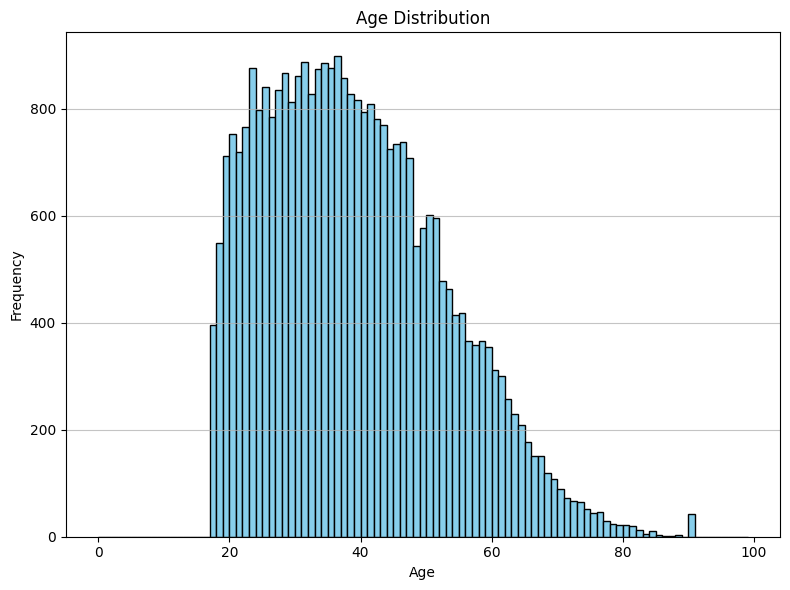

### Education Level Distribution

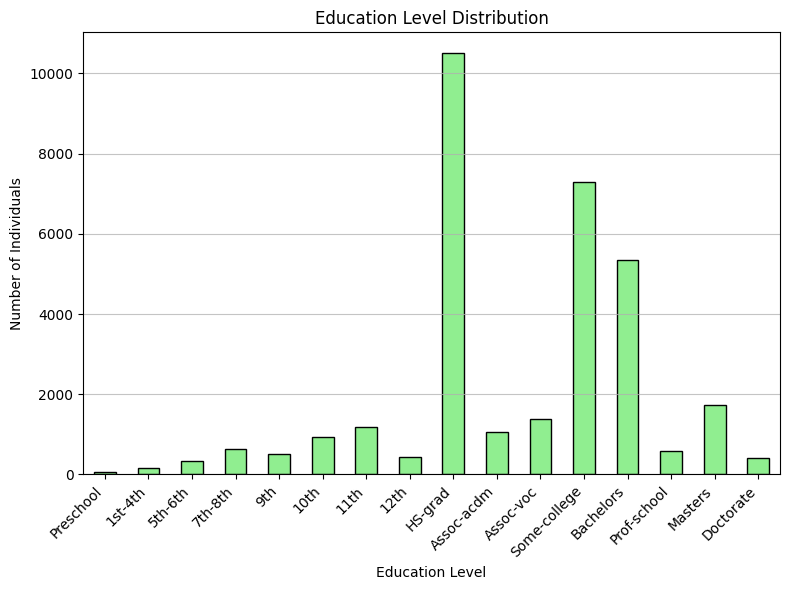

### Education Number Distribution

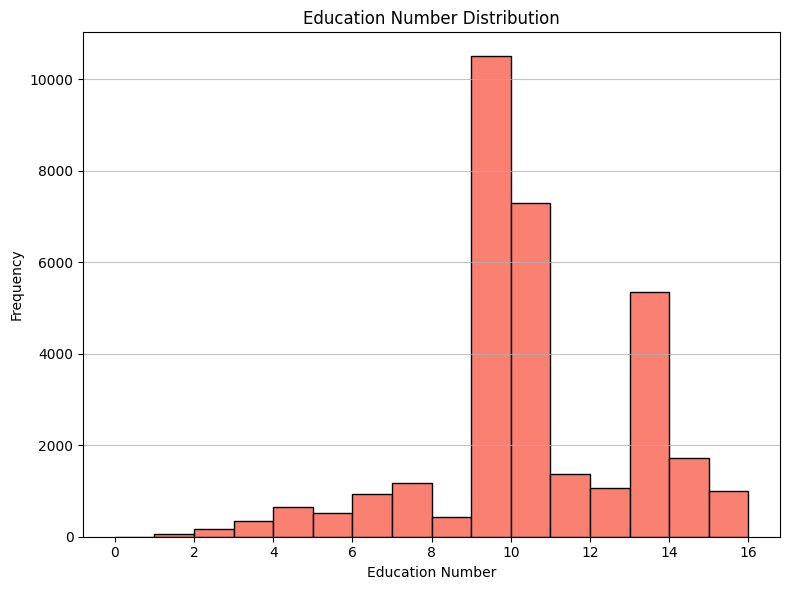

### Marital Status Distribution

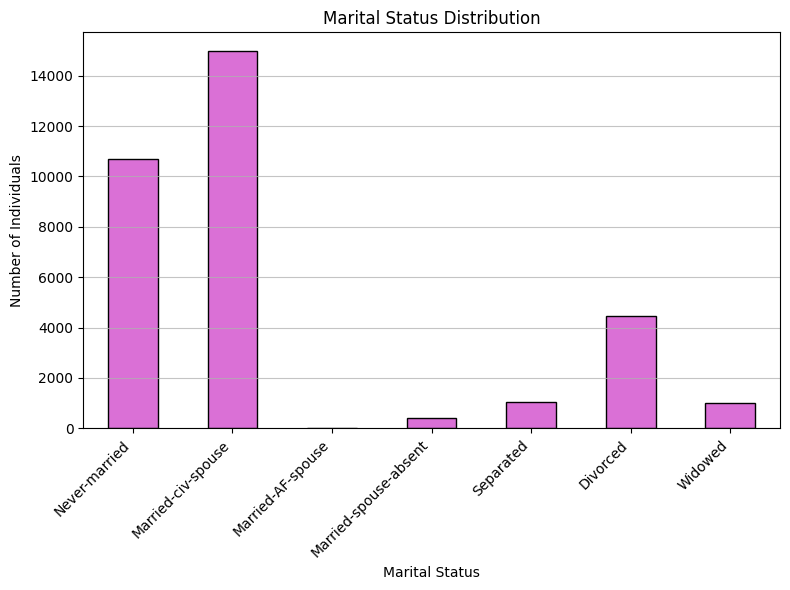

### Occupation Distribution

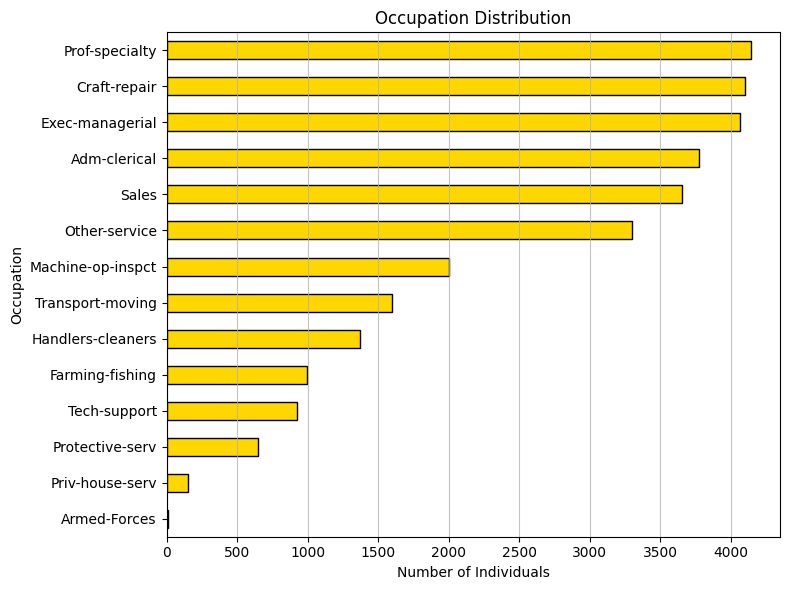

### Relationship Distribution

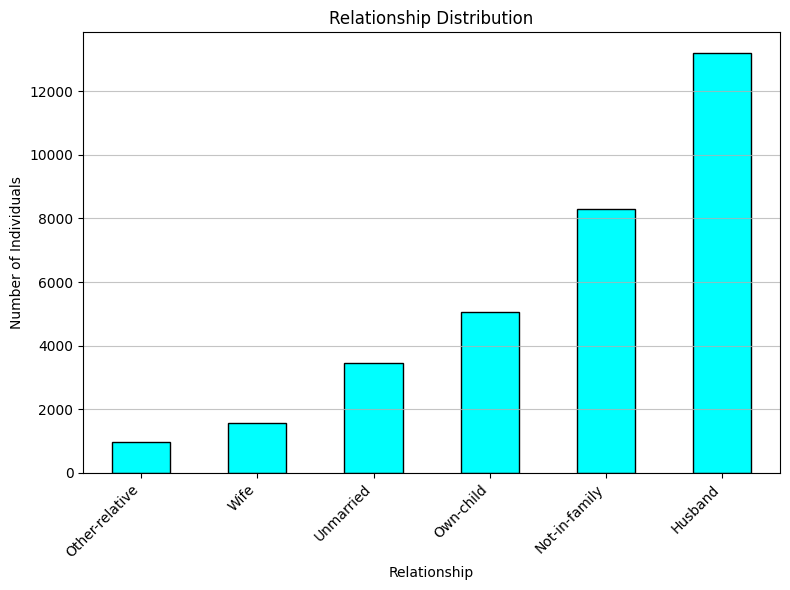

### Race Distribution

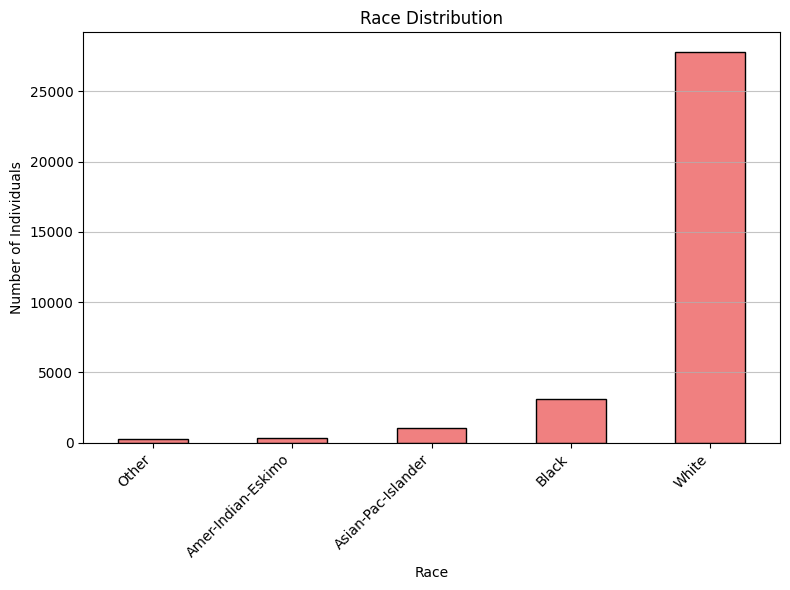

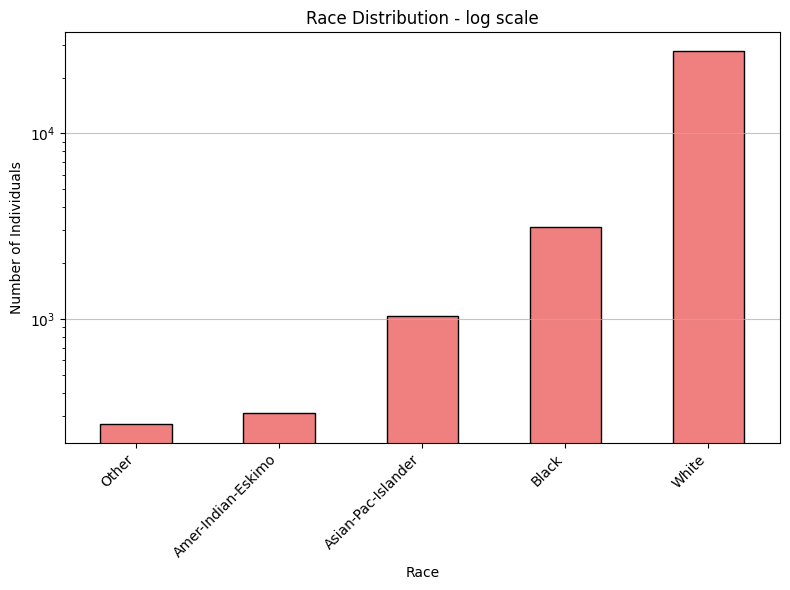

### Sex Distribution

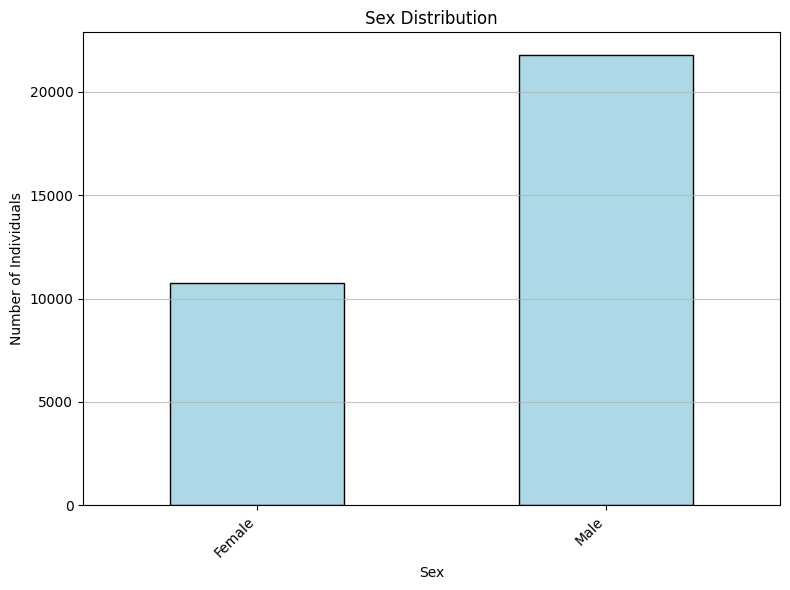

### Capital Gain Distribution

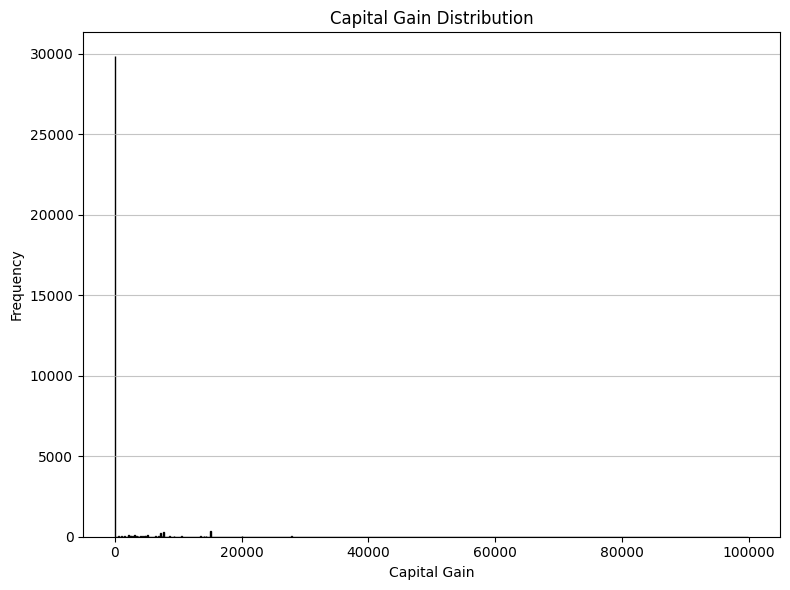

### Capital Loss Distribution

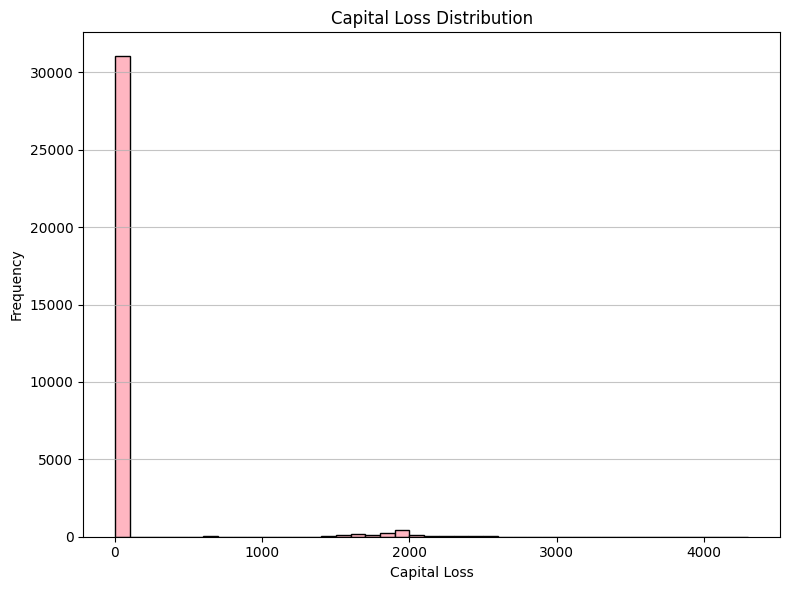

### Hours Per Week Distribution

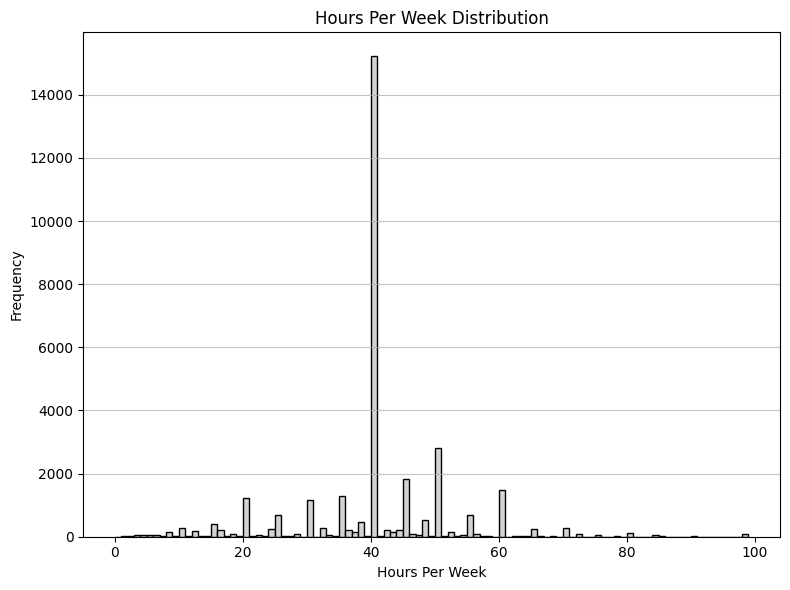

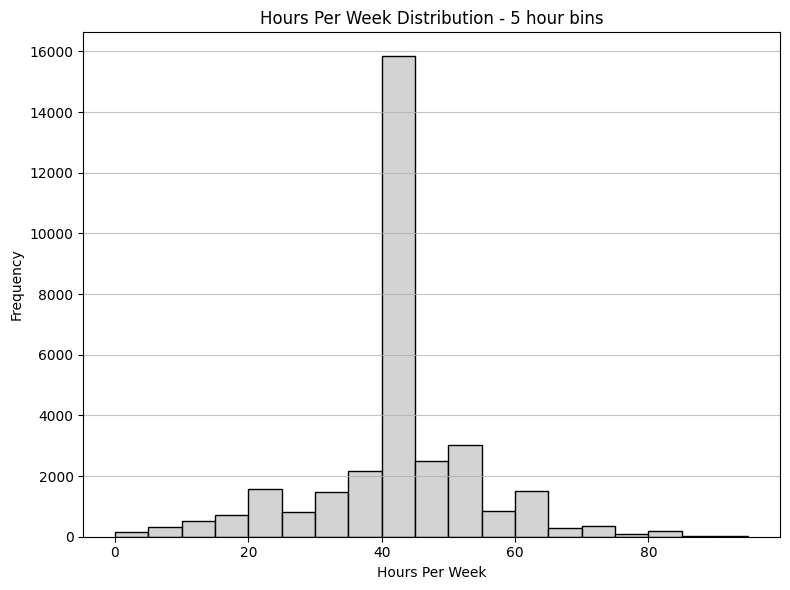

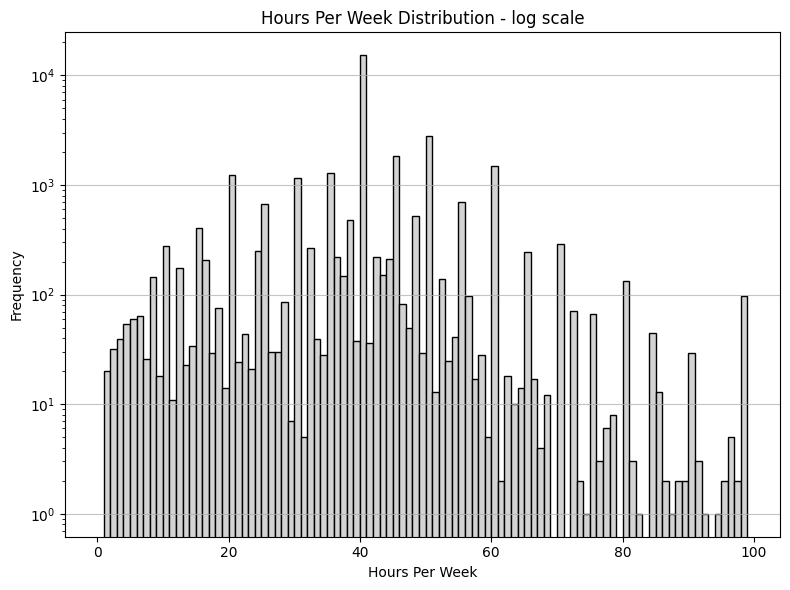

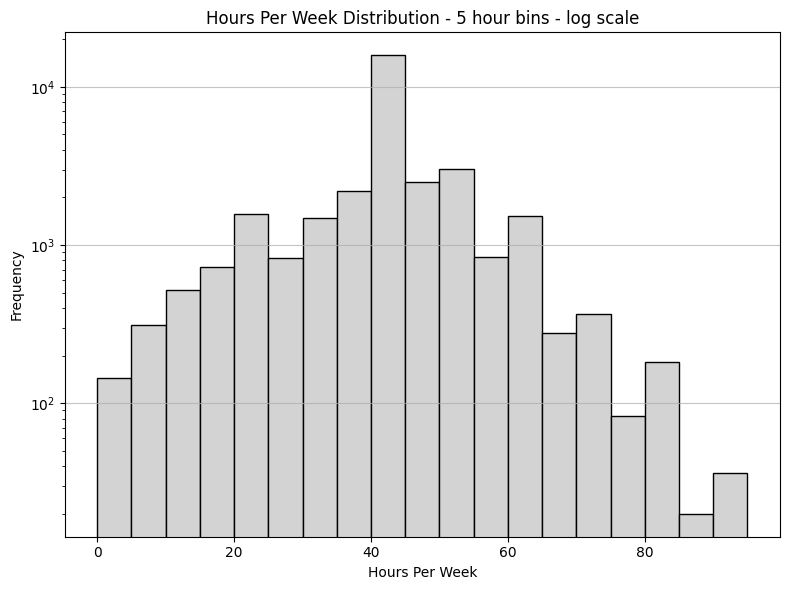

### Native Country Distribution

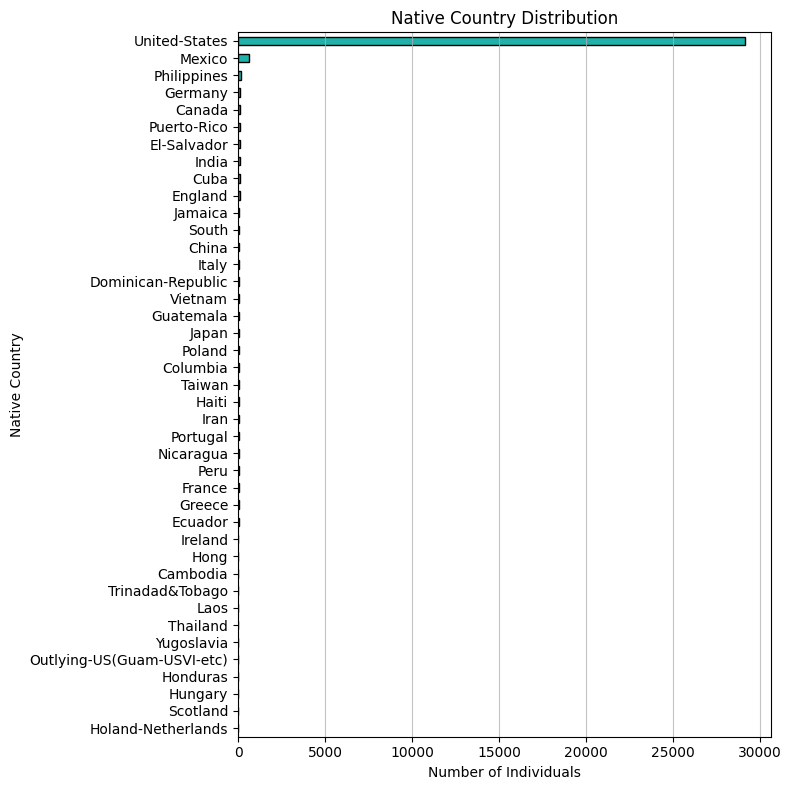

### Income Distribution

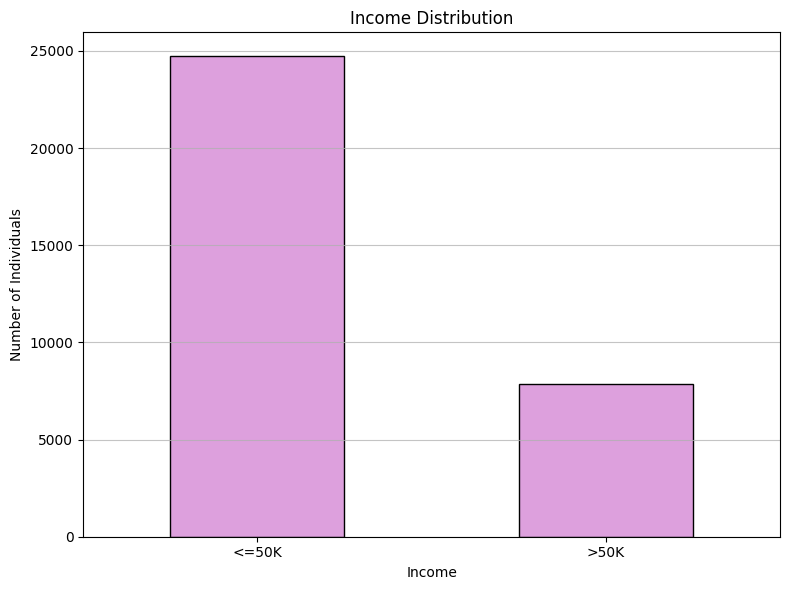

In [2]:
from projeto.eda import run_univariate_EDA

run_univariate_EDA(df)

## Filtragem e pré-processamento do dataset

Execute o código abaixo: 

In [ ]:
import pandas as pd


def cut_non_americans(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df['native.country'] == 'United-States']
    df = df.drop(columns=['native.country'])
    return df


df = cut_non_americans(df)

Responda: qual o motivo para fazer este procedimento?

***Resposta***:

## Separação treino-teste

In [ ]:
X = df.drop(columns=['income'])
y = df['income']

In [ ]:
from projeto.config import RANDOM_SEED, TEST_SIZE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
)

## Análise pós-separação treino-teste

Nem todos os pares de colunas merecem uma análise conjunta detalhada, isso rapidamente foge ao controle. Vamos privilegiar inicialmente:

- Análise descritiva:

    - Correlação entre *features* para identificar possiveis colinearidades simples e outras redundâncias de informação:

        - Entre *features* numéricas: correlação (e.g. Pearson)

        - Entre *features* categóricas: coeficiente de associação (e.g. [coeficiente V de Cramer](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V))

        - Entre uma *feature* categórica e uma contínua: podemos *discretizar* a *feature* contínua por quantis e tratar esse problema como sendo um problema de associação entre categóricas, mas é meio gambiarra isso... paciencia. 

    - Correlação entre *target* e *features*, para identificar possíveis *features* que sejam:
    
        - Perfeitamente preditoras do target: isso é um sinal de que o *target* e a *feature* são a mesma coisa, e fazer um projeto de *machine learning* para prever $y$ à partir de... $y$ (!) é obviamente perda de tempo e dinheiro.

        - Totalmente não-correlacionadas com o target: *TALVEZ* indique que a *feature* em questão é inútil, mas isso nem sempre é verdade. Pode ser que a *feature* tem o seu valor preditivo apenas quando combinada com outras features. Pode ser que esta *feature* tenha um valor preditivo perfeito, e que a correlação se mostra baixa apenas porque a relação entre esta *feature* e o *target* é não-linear (e portanto não vai ser percebida pela correlação de Pearson).

- Visualização:

    - Ver os gráficos apropriados para a visualização conjunta de *target* e cada *feature*, e de pares de *features* que chamaram a atenção na análise descritiva.

Rode o código abaixo e responda as seguintes questões:

- Liste 3 *features* que parecem ter alta associação com o *target*
- O que acontece com as variáveis `capital.gain` e `capital.loss`? Explique. 

In [ ]:
from projeto.eda import run_joint_EDA

run_joint_EDA(X_train, y_train)

# Gravando os arquivos de dados

Por fim, vamos gravar em disco os arquivos de dados resultantes da nossa análise, isso é fundamental!

In [ ]:
from projeto.dataset import save_processed_datasets

save_processed_datasets(
    X=X,
    y=y,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    base_path=base_path,
)

Responda: o que aconteceria se ao invés de gravar estes arquivos, fizéssemos a leitura do arquivo original e uma simples separação treino-teste no *notebook* de modelagem, sem maiores cuidados?

***Resposta***: